# Unsupervised Machine Learning: Clustering

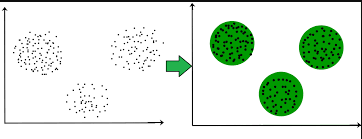

## Instalando e Carregando os Pacotes

In [1]:
import threadpoolctl                                # Gerenciamento de controladores para a execução paralela de threads
import pandas as pd                                 # type: ignore # Importa a biblioteca pandas para manipulação de dados
import numpy as np                                  # type: ignore # Importa a biblioteca numpy para operações numéricas
import matplotlib.pyplot as plt                     # type: ignore # Importa a biblioteca matplotlib para visualização gráfica
import seaborn as sns                               # type: ignore # Importa a biblioteca seaborn para gráficos estatísticos
from sklearn.cluster import KMeans                  # type: ignore # Importa o algoritmo KMeans para clustering
from sklearn.metrics import silhouette_score        # type: ignore # Importa a função para calcular o índice de silhueta
import plotly.io as pio                             # type: ignore # Importa a biblioteca plotly.io para configuração de renderização de gráficos
from sklearn.preprocessing import StandardScaler
pio.renderers.default = 'browser'                   # Define o navegador como o renderizador padrão para gráficos plotly
import warnings                                     # Biblioteca para controlar mensagens de aviso
warnings.filterwarnings('ignore')                   # Ignora mensagens de aviso

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Ricardo de Souza Silva" 

Author: Ricardo de Souza Silva



## Carregando e Explorando os Dados

In [3]:
dados_cartao = pd.read_csv('cartao_credito.csv')

In [4]:
dados_cartao.shape

(660, 7)

In [5]:
dados_cartao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [6]:
dados_cartao.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [7]:
novos_nomes = {
    'Sl_No': 'N_Serie',
    'Customer Key': 'Chave_Cliente',
    'Avg_Credit_Limit': 'Limite_Credito_Medio',
    'Total_Credit_Cards': 'Total_Cartoes_Credito',
    'Total_visits_bank': 'Visitas_Banco',
    'Total_visits_online': 'Visitas_Online',
    'Total_calls_made': 'Total_Chamadas'
}
# Renomear as colunas do DataFrame
dados_cartao.rename(columns=novos_nomes, inplace=True)

In [8]:
dados_cartao.head()

,N_Serie,Chave_Cliente,Limite_Credito_Medio,Total_Cartoes_Credito,Visitas_Banco,Visitas_Online,Total_Chamadas
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


## Análise Exploratória e Limpeza de Dados

In [9]:
dados_cartao.isnull().sum()

N_Serie                  0
Chave_Cliente            0
Limite_Credito_Medio     0
Total_Cartoes_Credito    0
Visitas_Banco            0
Visitas_Online           0
Total_Chamadas           0
dtype: int64

### Verificando outliers

In [10]:
vizualizacao_outLiers = dados_cartao.drop(['N_Serie', 'Chave_Cliente'], axis=1)

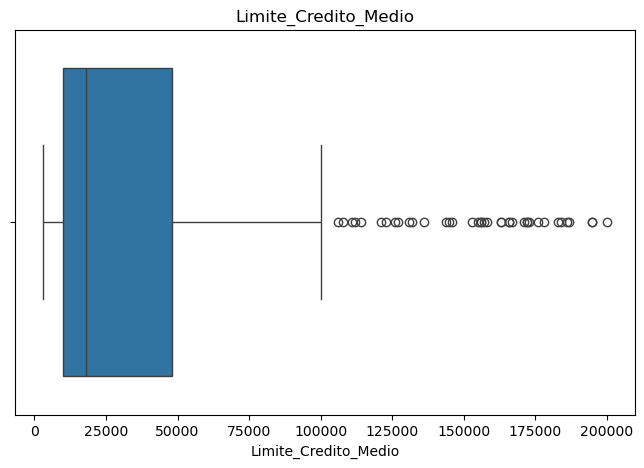

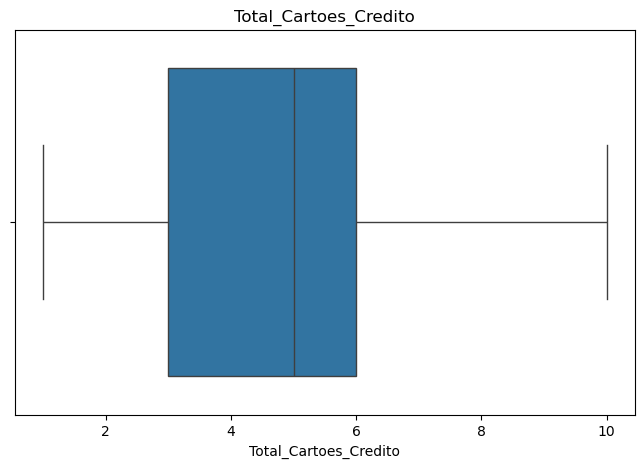

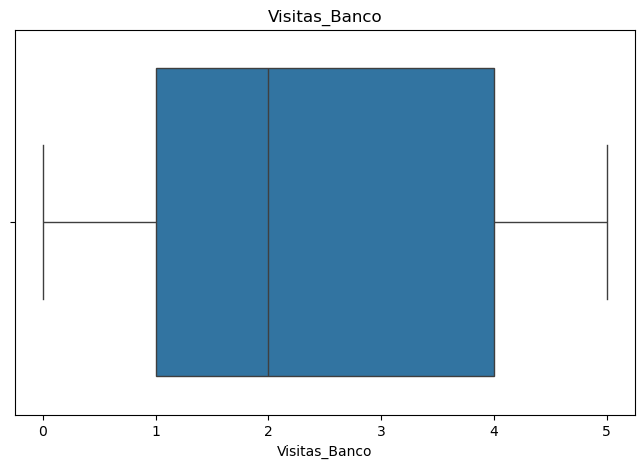

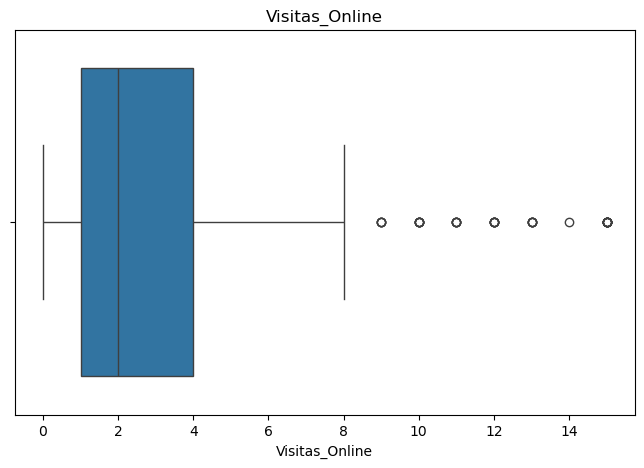

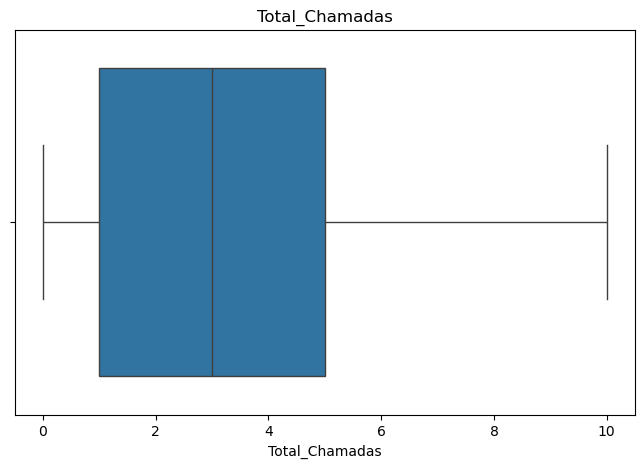

In [11]:
for colunas in vizualizacao_outLiers:
    if vizualizacao_outLiers[colunas].dtype in ['int64']:
        plt.figure(figsize = (8, 5))                    # Define o tamanho da figura para o gráfico
        sns.boxplot(x = vizualizacao_outLiers[colunas])                 # Cria um boxplot para a coluna numérica
        plt.title(colunas)                               # Define o título do gráfico como o nome da coluna
        plt.show()                                      # Exibe o gráfico

In [12]:
# Define o Intervalo Interquartil
Q1 = vizualizacao_outLiers.quantile(0.25)  # Calcula o primeiro quartil (25º percentil) para cada coluna do DataFrame
Q3 = vizualizacao_outLiers.quantile(0.75)  # Calcula o terceiro quartil (75º percentil) para cada coluna do DataFrame
IQR = Q3 - Q1               # Calcula o intervalo interquartil (IQR) subtraindo Q1 de Q3
print(IQR)                  # Exibe o intervalo interquartil para cada coluna


Limite_Credito_Medio     38000.0
Total_Cartoes_Credito        3.0
Visitas_Banco                3.0
Visitas_Online               3.0
Total_Chamadas               4.0
dtype: float64


In [13]:
# Vamos checar os valores que estão 1.5 acima ou abaixo do IQR. Esses valores são considerados outliers.
outliers = ((vizualizacao_outLiers < (Q1 - 2.5 * IQR)) | (vizualizacao_outLiers > (Q3 + 2.5 * IQR))).any(axis = 1)  
# Identifica outliers em cada linha do DataFrame com base no intervalo interquartil (IQR), considerando valores 
# que estão além de 2,5 vezes o IQR abaixo de Q1 ou acima de Q3

In [14]:
# Filtramos os outliers
df_outliers = vizualizacao_outLiers[outliers]  # Cria um novo DataFrame contendo apenas as linhas identificadas como outliers

In [15]:
# Visualizamos os outliers
df_outliers  # Exibe o DataFrame que contém apenas as linhas identificadas como outliers

,Limite_Credito_Medio,Total_Cartoes_Credito,Visitas_Banco,Visitas_Online,Total_Chamadas
4,100000,6,0,12,3
612,157000,9,1,14,1
614,163000,8,1,7,1
617,136000,8,0,13,0
618,121000,7,0,13,2
619,158000,7,0,13,0
620,108000,10,0,15,1
621,166000,9,1,12,2
622,176000,10,1,15,2
623,166000,10,0,7,0


In [16]:
dados_cartao['Limite_Credito_Medio'].describe()

count       660.000000
mean      34574.242424
std       37625.487804
min        3000.000000
25%       10000.000000
50%       18000.000000
75%       48000.000000
max      200000.000000
Name: Limite_Credito_Medio, dtype: float64

In [17]:
df_outliers['Limite_Credito_Medio'].describe()

count        37.000000
mean     153432.432432
std       30946.675051
min       84000.000000
25%      136000.000000
50%      158000.000000
75%      173000.000000
max      200000.000000
Name: Limite_Credito_Medio, dtype: float64

## Correlação de Dados

In [18]:
correlacao_dados = vizualizacao_outLiers.corr()
correlacao_dados

,Limite_Credito_Medio,Total_Cartoes_Credito,Visitas_Banco,Visitas_Online,Total_Chamadas
Limite_Credito_Medio,1.000000,0.608860,-0.100312,0.551385,-0.414352
Total_Cartoes_Credito,0.608860,1.000000,0.315796,0.167758,-0.651251
Visitas_Banco,-0.100312,0.315796,1.000000,-0.551861,-0.506016
Visitas_Online,0.551385,0.167758,-0.551861,1.000000,0.127299
Total_Chamadas,-0.414352,-0.651251,-0.506016,0.127299,1.000000


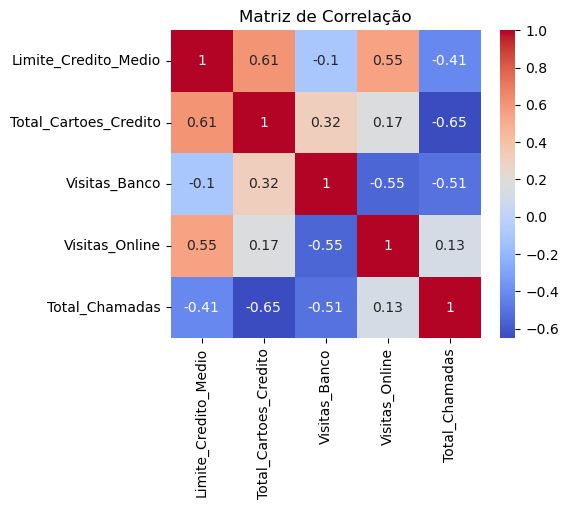

In [19]:
# Plot
plt.figure(figsize = (5, 4))                                       # Define o tamanho da figura para o gráfico
sns.heatmap(correlacao_dados, annot = True, cmap = 'coolwarm')      # Cria um mapa de calor da matriz de correlação com anotações e coloração 'coolwarm'
plt.title('Matriz de Correlação')                                   # Define o título do gráfico
plt.show()                                                          # Exibe o gráfico

Esta matriz de correlação mostra as relações entre as variáveis **Limite_Credito_Medio**, **Total_Cartoes_Credito**, **Visitas_Banco**, **Visitas_Online** e **Total_Chamadas**. Vamos analisar cada uma dessas correlações para entender melhor os relacionamentos entre essas variáveis.

### Análise das correlações:

1. **Limite_Credito_Medio**:
   - **Total_Cartoes_Credito**: Correlação moderada positiva (**0.6089**). Isso indica que clientes com mais cartões de crédito tendem a ter limites de crédito mais altos.
   - **Visitas_Banco**: Correlação negativa fraca (**-0.1003**). Isso sugere que as visitas ao banco não estão fortemente relacionadas ao limite de crédito.
   - **Visitas_Online**: Correlação moderada positiva (**0.5514**). Clientes que acessam mais os serviços online tendem a ter maiores limites de crédito.
   - **Total_Chamadas**: Correlação moderada negativa (**-0.4144**). Clientes com maiores limites de crédito tendem a fazer menos chamadas para o banco, possivelmente por terem menos dúvidas ou problemas.

2. **Total_Cartoes_Credito**:
   - **Visitas_Banco**: Correlação positiva moderada (**0.3158**), indicando que clientes com mais cartões de crédito podem também fazer mais visitas físicas ao banco.
   - **Visitas_Online**: Correlação fraca positiva (**0.1678**), sugerindo uma relação mínima entre o número de cartões de crédito e o uso de serviços online.
   - **Total_Chamadas**: Correlação negativa forte (**-0.6513**). Clientes com mais cartões de crédito tendem a fazer menos chamadas ao banco, possivelmente por serem mais experientes no uso de crédito ou resolverem questões de outras formas.

3. **Visitas_Banco**:
   - **Visitas_Online**: Correlação negativa moderada (**-0.5519**). Clientes que visitam o banco com frequência tendem a utilizar menos os serviços online, indicando que esses canais podem ser substitutos.
   - **Total_Chamadas**: Correlação negativa moderada (**-0.5060**), sugerindo que clientes que visitam o banco com mais frequência também fazem menos chamadas telefônicas. Isso pode indicar que resolvem suas dúvidas presencialmente.

4. **Visitas_Online**:
   - **Total_Chamadas**: Correlação fraca positiva (**0.1273**). Há uma relação mínima entre o uso de serviços online e o número de chamadas realizadas, o que pode sugerir que os clientes ainda fazem chamadas mesmo que utilizem serviços online.

5. **Total_Chamadas**:
   - As correlações já foram explicadas em outros pontos. De forma geral, a variável **Total_Chamadas** tem correlações negativas com quase todas as outras variáveis, exceto com **Visitas_Online**, o que sugere que clientes que ligam mais tendem a usar menos serviços físicos ou ter menos cartões.

### Resumo:

- **Clientes com mais cartões de crédito tendem a ter maiores limites de crédito** e fazem menos chamadas ao banco.
- **Clientes que visitam mais o banco tendem a usar menos serviços online**, sugerindo uma substituição entre esses canais.
- **Limites de crédito mais altos estão associados a mais visitas online e menos chamadas telefônicas**, o que pode indicar que clientes com perfis de crédito mais altos estão mais familiarizados com o ambiente digital e resolvem suas necessidades sem precisar de tanto suporte.

## Padronizador de Dados

In [20]:
# Cria o padronizador
scaler = StandardScaler()  # Cria uma instância do objeto StandardScaler para padronização dos dados

In [21]:
# Padronizando as Variáveis
dados_padronizados = pd.DataFrame(scaler.fit_transform(vizualizacao_outLiers), columns = vizualizacao_outLiers.columns)  
# Aplica a padronização aos dados do DataFrame usando o StandardScaler e cria um novo DataFrame com as mesmas colunas

In [22]:
dados_padronizados.head()  # Exibe as primeiras 5 linhas do DataFrame padronizado para visualização inicial dos dados escalados

,Limite_Credito_Medio,Total_Cartoes_Credito,Visitas_Banco,Visitas_Online,Total_Chamadas
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


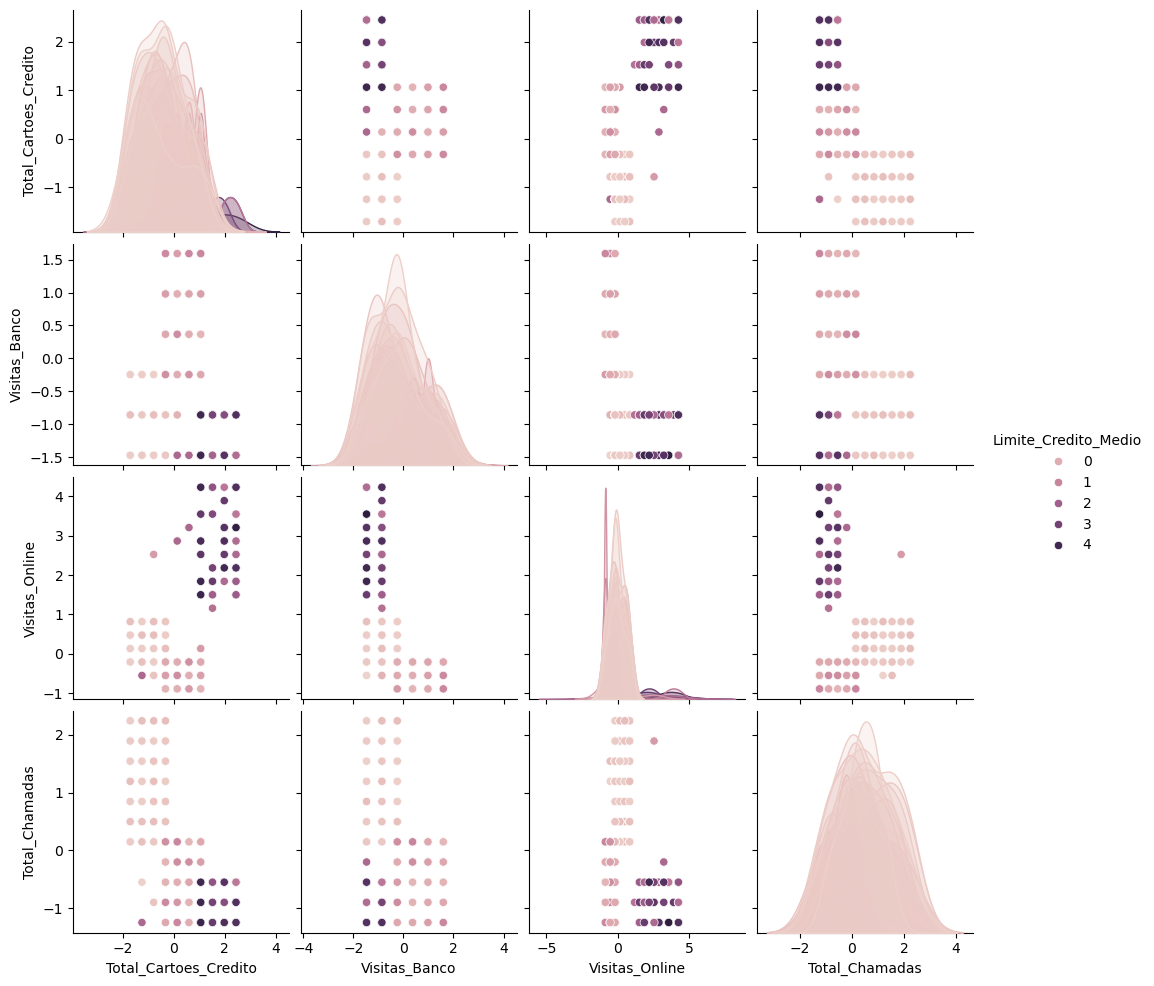

In [23]:
# Visualização de Dados com PairPlot
sns.pairplot(dados_padronizados, hue = 'Limite_Credito_Medio', diag_kind = 'kde')  # Cria um gráfico de pares para visualizar a relação entre as variáveis, colorindo por 'Cancelou' e usando KDE para os histogramas na diagonal
plt.show()  # Exibe o gráfico gerado

## Definindo o Valor de K em Modelos de Clusterização

### Método do Cotovelo (Elbow Method)

Este é um dos métodos mais comuns para encontrar o valor ótimo de k. Ele envolve executar o algoritmo de agrupamento para diferentes valores de k e calcular a soma dos quadrados intra-cluster (SSE) para cada valor de k. O valor de k onde a redução da SSE começa a diminuir mais lentamente (o "cotovelo" da curva) é considerado o valor ótimo de k.

A soma dos quadrados intra-cluster (SSE, do inglês "Sum of Squared Errors") é uma medida que indica o quão compactos são os clusters formados em um algoritmo de agrupamento, como o KMeans. O SSE é uma forma de avaliar a qualidade dos clusters, ao quantificar o quão próximos os pontos dentro de cada cluster estão do centroide desse cluster.

Imagine que cada cluster é um círculo e os pontos dentro desse círculo são os elementos do cluster. O centro desse círculo é o centroide, que é a média de todos os pontos no cluster. O SSE mede a soma das distâncias ao quadrado de cada ponto até o centroide do seu respectivo cluster. Ou seja, para cada ponto, calcula-se a distância até o centroide, eleva-se essa distância ao quadrado e soma-se todos esses valores.

Quanto menor for o SSE, mais próximos os pontos estão dos seus centroides, indicando que os clusters são mais compactos e bem definidos. Um SSE grande, por outro lado, indica que os pontos estão mais dispersos em torno dos centroides, sugerindo que os clusters podem não ser tão bem definidos.

In [24]:
# Lista para armazenar o SSE
sse = []

# Range de valores de k a serem testados
k_range = range(1, 11)  # Define o intervalo de valores de K a serem testados, variando de 1 a 10 para o algoritmo KMeans

# Testando os valores
for k in k_range:                   # Itera sobre cada valor de K no intervalo definido
    kmeans = KMeans(n_clusters = k) # Cria uma instância do KMeans com o número atual de clusters (k)
    kmeans.fit(dados_padronizados)           # Aplica o algoritmo KMeans aos dados padronizados
    sse.append(kmeans.inertia_)     # Adiciona a soma dos quadrados das distâncias (SSE) do modelo à lista 'sse'

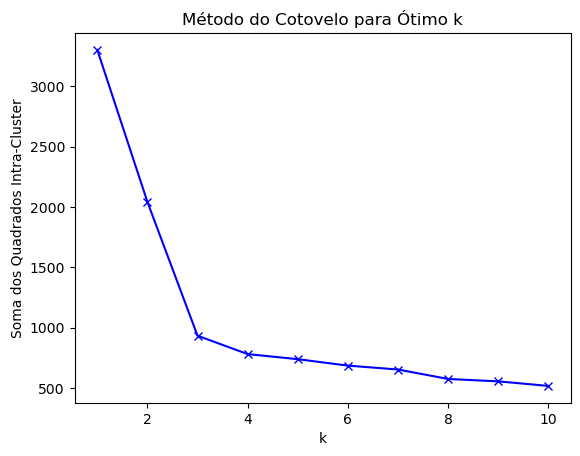

In [25]:
# Plot
plt.plot(k_range, sse, 'bx-')                   # Plota a soma dos quadrados intra-cluster (SSE) em relação a diferentes valores de k, usando um marcador 'x'
plt.xlabel('k')                                 # Define o rótulo do eixo x como 'k'
plt.ylabel('Soma dos Quadrados Intra-Cluster')  # Define o rótulo do eixo y
plt.title('Método do Cotovelo para Ótimo k')    # Define o título do gráfico
plt.show()                                      # Exibe o gráfico gerado

### Método da Silhueta (Silhouette Method)

O método da Silhueta é uma técnica utilizada para avaliar a qualidade dos clusters formados em um algoritmo de agrupamento, como o KMeans. Ele fornece uma medida de quão bem um ponto foi agrupado e se ele está no cluster correto.

O cálculo da Silhueta para um ponto envolve duas distâncias:

**Coesão (a)**: A média da distância entre o ponto e todos os outros pontos no mesmo cluster. Quanto menor for esse valor, mais próximo o ponto está dos outros pontos do seu cluster, indicando uma boa coesão.

**Separação (b)**: A menor média da distância entre o ponto e os pontos em um cluster diferente. Quanto maior for esse valor, mais distante o ponto está dos pontos dos outros clusters, indicando uma boa separação.

O valor de s varia de -1 a 1:

- Um valor próximo de 1 indica que o ponto está bem agrupado dentro de seu cluster e longe dos outros clusters.
- Um valor próximo de 0 indica que o ponto está próximo à fronteira entre dois clusters.
- Um valor próximo de -1 indica que o ponto pode ter sido agrupado no cluster errado.

A média da Silhueta de todos os pontos no conjunto de dados pode ser usada como uma medida geral da qualidade do agrupamento. Quanto mais próximo de 1 for esse valor médio, melhor é a qualidade dos clusters formados. O método da Silhueta é útil para determinar o número ótimo de clusters em um conjunto de dados, pois você pode executar o algoritmo de agrupamento com diferentes números de clusters e escolher aquele que resulta na maior média da Silhueta.

In [26]:
# Lista para o Silhouette score
sil_score = []

# Loop pelo range de valores de k a serem testados
for k in k_range:  # Itera sobre cada valor de K no intervalo definido
    kmeans = KMeans(n_clusters = k)  # Cria uma instância do KMeans com o número atual de clusters (k)
    kmeans.fit(dados_padronizados)  # Aplica o algoritmo KMeans aos dados padronizados
    
    # Silhouette score não é definido para k = 1, então filtramos
    if k != 1:  # Verifica se k não é igual a 1, pois a silhueta não é definida para um único cluster
        sil_score.append(silhouette_score(dados_padronizados, kmeans.labels_))  # Calcula e adiciona o coeficiente de silhueta à lista 'sil_score' para o modelo atual

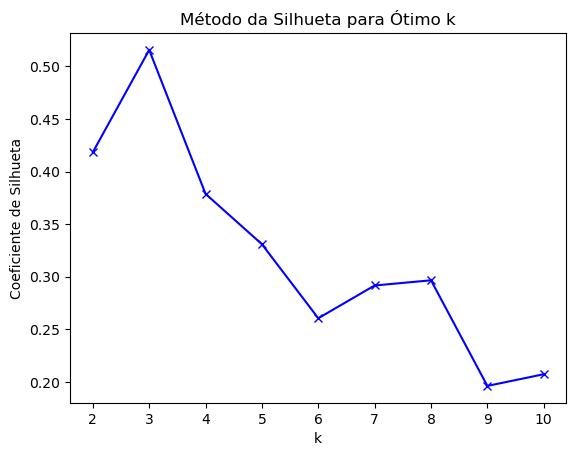

In [27]:
# Plot
plt.plot(k_range[1:], sil_score, 'bx-')         # Plota o coeficiente de silhueta em relação a diferentes valores de k, começando de 2 até 10
plt.xlabel('k')                                 # Define o rótulo do eixo x como 'k'
plt.ylabel('Coeficiente de Silhueta')           # Define o rótulo do eixo y
plt.title('Método da Silhueta para Ótimo k')    # Define o título do gráfico
plt.show()                                      # Exibe o gráfico gerado

## Construção da Primeira Versão do Modelo de Clusterização

In [28]:
modelo_kmeans_01 = KMeans(n_clusters=6, random_state=42)

In [29]:
dados_cartao['cluster'] = modelo_kmeans_01.fit_predict(dados_padronizados)

In [30]:
dados_cartao.sample(10)

,N_Serie,Chave_Cliente,Limite_Credito_Medio,Total_Cartoes_Credito,Visitas_Banco,Visitas_Online,Total_Chamadas,cluster
298,299,38994,12000,6,5,0,2,3
67,68,76205,9000,4,2,2,6,2
371,372,17649,6000,5,2,2,1,0
336,337,62483,12000,4,4,2,1,3
57,58,17937,6000,2,0,2,10,5
101,102,96213,11000,1,1,5,9,5
481,482,75065,30000,7,3,1,0,0
244,245,39122,5000,7,3,2,4,0
29,30,29112,8000,4,0,4,7,2
461,462,55170,38000,4,4,2,3,3


In [31]:
dados_limpos = dados_cartao.drop(['N_Serie', 'Chave_Cliente'], axis=1)

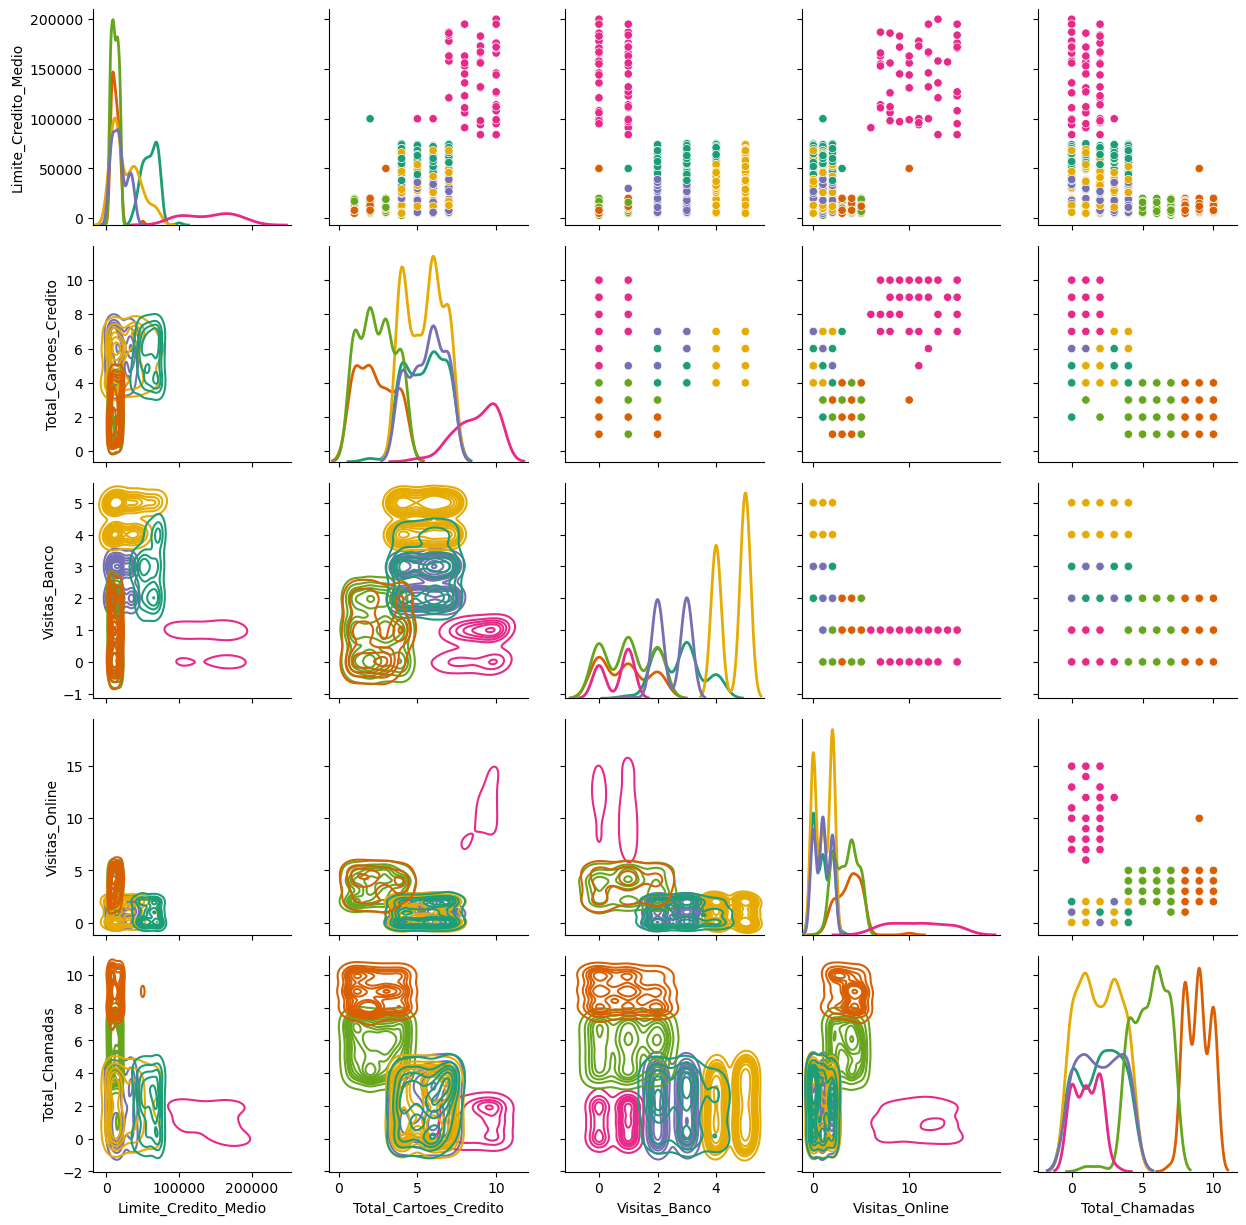

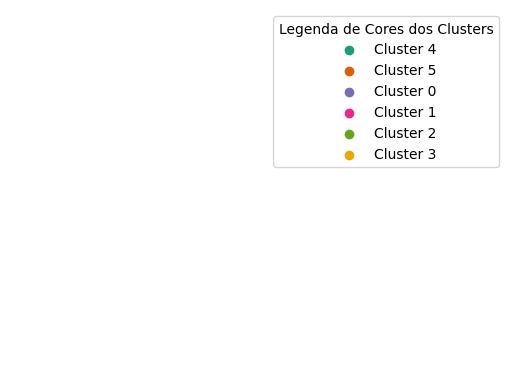

In [32]:
# Criando um mapa de cores baseado na paleta 'Dark2'
palette = sns.color_palette('Dark2', n_colors = len(dados_limpos['cluster'].unique()))  # Gera uma paleta de cores para o número único de clusters
color_map = dict(zip(dados_limpos['cluster'].unique(), palette))  # Cria um dicionário que associa cada cluster a uma cor

# Plotando o gráfico de grid com os clusters e mostrando o mapa de cores
g = sns.PairGrid(dados_limpos, hue = 'cluster', palette = color_map, diag_sharey = False)  # Cria uma grade de gráficos para visualizar os dados agrupados por cluster
g.map_upper(sns.scatterplot)  # Plota gráficos de dispersão na parte superior da grade
g.map_lower(sns.kdeplot)  # Plota gráficos de densidade de kernel na parte inferior da grade
g.map_diag(sns.kdeplot, lw = 2)  # Plota gráficos de densidade de kernel nas diagonais
plt.show()  # Exibe os gráficos gerados

# Mostrando o mapa de cores
for cluster, color in color_map.items():  # Itera sobre os clusters e suas cores associadas
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')  # Plota um ponto invisível para cada cluster para criar a legenda
plt.legend(title = 'Legenda de Cores dos Clusters')  # Exibe a legenda dos clusters
plt.axis('off')  # Remove os eixos do gráfico
plt.show()  # Exibe a legenda

A análise do gráfico exibido mostra a dispersão das variáveis do seu conjunto de dados em relação às outras, possivelmente após algum tipo de redução dimensional ou agrupamento (clusters). O gráfico parece ser um **pairplot** com contornos de densidade sobrepostos para facilitar a visualização de padrões entre as variáveis. Aqui está uma análise inicial:

### Observações por pares de variáveis:
1. **Limite_Credito_Medio vs. Total_Cartoes_Credito**:
   - Parece haver uma relação direta entre essas variáveis, como esperado. Quanto maior o número de cartões de crédito, maior tende a ser o limite de crédito.
   - Os contornos mostram que os clientes com limites de crédito maiores e mais cartões de crédito estão concentrados em faixas distintas.

2. **Visitas_Banco e Total_Chamadas**:
   - Estas duas variáveis apresentam algum nível de associação negativa, especialmente nos clientes que fazem menos visitas ao banco, mas têm um maior número de chamadas.
   - Pode sugerir que os clientes que utilizam mais o atendimento telefônico tendem a ir menos ao banco fisicamente.

3. **Total_Chamadas vs. Visitas_Online**:
   - Há uma ligeira dispersão, mas não parece haver um padrão claro. A densidade sugere uma falta de correlação forte, o que pode indicar que clientes que utilizam mais os canais online não necessariamente utilizam o atendimento por chamadas.

4. **Distribuição individual das variáveis**:
   - Variáveis como **Total_Cartoes_Credito**, **Visitas_Banco** e **Visitas_Online** parecem ser discretas, com valores inteiros limitados a uma faixa específica.
   - **Limite_Credito_Medio** tem uma distribuição mais ampla, indicando que os clientes variam bastante nesse aspecto.

5. **Clusters (cores)**:
   - As diferentes cores no gráfico indicam os **clusters** de clientes, provavelmente originados de um algoritmo de agrupamento como **K-Means** ou **GMM**.
   - Notamos que os clusters se sobrepõem em várias variáveis, o que pode indicar que as fronteiras entre os grupos não são claramente definidas.
   - No entanto, em algumas variáveis, como **Limite_Credito_Medio** e **Total_Cartoes_Credito**, os clusters estão bem separados, sugerindo que essas variáveis desempenham um papel mais forte na segmentação dos clientes.

### Análise de Qualidade dos Clusters:
- **Sobreposição entre clusters**: A presença de sobreposição entre os contornos de densidade sugere que os clusters não estão perfeitamente separados, o que pode ser um sinal de que as variáveis usadas para o agrupamento não conseguem separar os grupos de forma ideal.
  
- **Densidade**: Algumas áreas têm alta densidade de pontos, o que indica que os grupos estão concentrados em certas faixas de valores, enquanto em outras áreas, os dados são mais dispersos.

### Sugestões para melhorar a análise:
- **Redução de dimensionalidade**: Técnicas como **PCA (Análise de Componentes Principais)** podem ajudar a verificar se é possível separar melhor os clusters em um espaço de variáveis reduzidas.
- **Avaliação de qualidade de clusters**: Calcular métricas como **silhouette score** ou **Dunn index** pode fornecer uma visão quantitativa de quão bem os clusters estão separados.

Se você puder compartilhar os dados ou mais detalhes sobre o processo de clustering, posso fazer uma análise mais aprofundada e sugerir melhorias.

## Construção da Segunda Versão do Modelo de Clusterização

In [33]:
modelo_kmeans_02 = KMeans(n_clusters=4, random_state=42)

In [34]:
dados_cartao['cluster'] = modelo_kmeans_02.fit_predict(dados_padronizados)

In [35]:
dados_cartao.sample(10)

,N_Serie,Chave_Cliente,Limite_Credito_Medio,Total_Cartoes_Credito,Visitas_Banco,Visitas_Online,Total_Chamadas,cluster
460,461,94595,26000,6,4,2,3,3
273,274,53207,18000,6,5,2,1,3
638,639,17538,153000,8,1,7,1,1
489,490,42921,50000,7,5,2,1,3
637,638,88442,173000,9,1,11,0,1
407,408,17703,50000,5,4,0,1,3
622,623,53916,176000,10,1,15,2,1
524,525,90860,59000,7,3,2,4,0
556,557,79885,60000,4,5,0,4,3
6,7,48370,100000,5,0,11,2,1


In [36]:
dados_limpos = dados_cartao.drop(['N_Serie', 'Chave_Cliente'], axis=1)

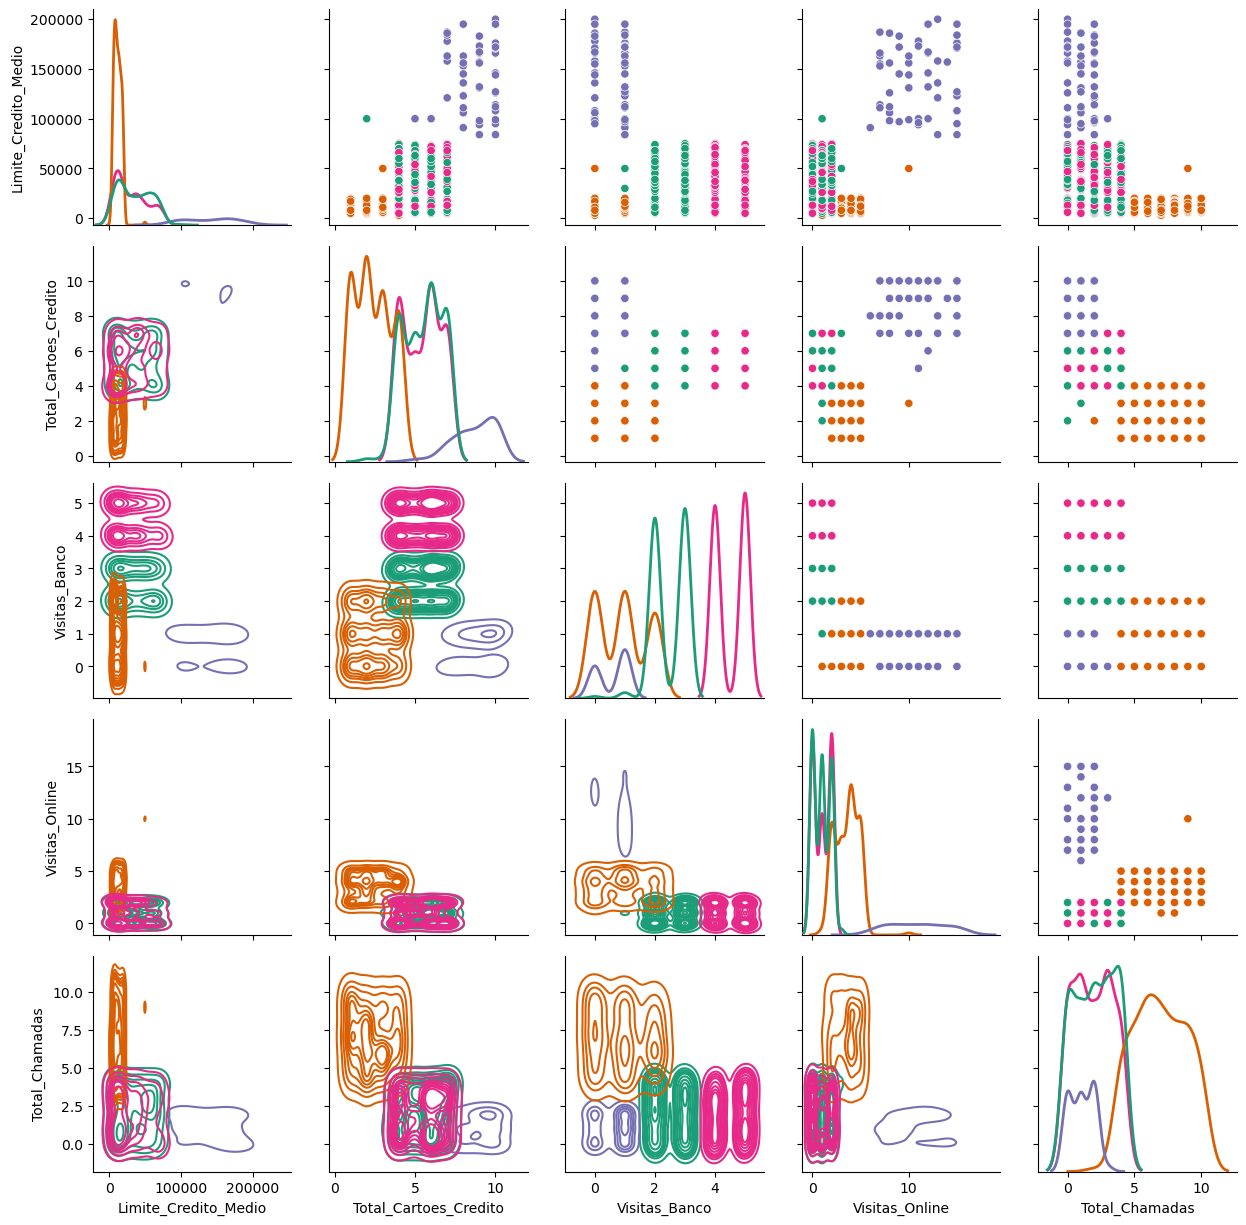

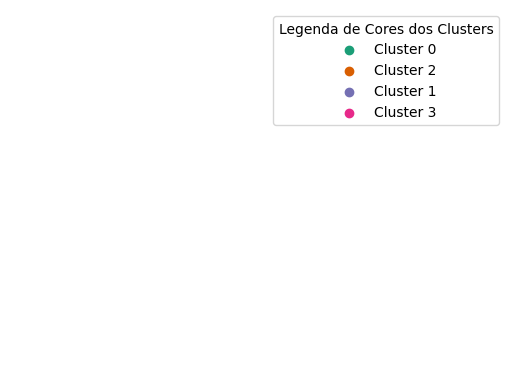

In [37]:
# Criando um mapa de cores baseado na paleta 'Dark2'
palette = sns.color_palette('Dark2', n_colors = len(dados_limpos['cluster'].unique()))  # Gera uma paleta de cores para o número único de clusters
color_map = dict(zip(dados_limpos['cluster'].unique(), palette))  # Cria um dicionário que associa cada cluster a uma cor

# Plotando o gráfico de grid com os clusters e mostrando o mapa de cores
g = sns.PairGrid(dados_limpos, hue = 'cluster', palette = color_map, diag_sharey = False)  # Cria uma grade de gráficos para visualizar os dados agrupados por cluster
g.map_upper(sns.scatterplot)  # Plota gráficos de dispersão na parte superior da grade
g.map_lower(sns.kdeplot)  # Plota gráficos de densidade de kernel na parte inferior da grade
g.map_diag(sns.kdeplot, lw = 2)  # Plota gráficos de densidade de kernel nas diagonais
plt.show()  # Exibe os gráficos gerados

# Mostrando o mapa de cores
for cluster, color in color_map.items():  # Itera sobre os clusters e suas cores associadas
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')  # Plota um ponto invisível para cada cluster para criar a legenda
plt.legend(title = 'Legenda de Cores dos Clusters')  # Exibe a legenda dos clusters
plt.axis('off')  # Remove os eixos do gráfico
plt.show()  # Exibe a legenda

A nova visualização é bastante semelhante à anterior, com o uso de cores para representar clusters, bem como a sobreposição de contornos de densidade para melhor visualizar a distribuição dos dados e suas relações. Aqui está uma análise atualizada dos clusters com base nesse gráfico:

### Observações:
1. **Limite_Credito_Medio vs. Total_Cartoes_Credito**:
   - Continua sendo o par de variáveis que apresenta a relação mais clara, com clusters que são relativamente bem separados em termos de contornos de densidade. Isso sugere que essas variáveis desempenham um papel significativo na distinção entre grupos de clientes.

2. **Visitas_Banco**:
   - Observa-se uma separação clara entre clusters em termos do número de visitas ao banco. Alguns clusters são caracterizados por uma frequência baixa de visitas, enquanto outros possuem um padrão de visitas mais frequente.
   - O número de visitas ao banco parece estar inversamente relacionado às **Visitas_Online**, o que faz sentido, já que clientes que utilizam mais o canal digital tendem a ir menos ao banco.

3. **Total_Chamadas**:
   - A variável **Total_Chamadas** mostra uma forte concentração de valores baixos para a maioria dos clusters. No entanto, os clusters variam em termos de contornos para essa variável, sugerindo que diferentes perfis de clientes utilizam o atendimento telefônico de maneiras diferentes.
   - A relação entre **Total_Chamadas** e **Visitas_Banco** mostra algum nível de separação entre clusters, o que indica que clientes que ligam mais tendem a visitar menos o banco, exceto em alguns casos específicos.

4. **Distribuição das variáveis**:
   - Como anteriormente observado, variáveis como **Total_Cartoes_Credito**, **Visitas_Banco**, **Visitas_Online** e **Total_Chamadas** têm distribuições discretas. 
   - **Limite_Credito_Medio** ainda apresenta uma faixa bem mais ampla de valores, o que faz com que os clusters se distribuam de maneira desigual nessa dimensão.

### Qualidade dos Clusters:
- **Separação dos clusters**: A separação entre os clusters parece ligeiramente mais clara nesta visualização em comparação à anterior, especialmente em variáveis como **Total_Cartoes_Credito** e **Visitas_Banco**. No entanto, ainda há sobreposição em algumas áreas, especialmente nas variáveis **Total_Chamadas** e **Visitas_Online**.
- **Agrupamento claro**: Em algumas combinações de variáveis, como **Visitas_Banco** e **Total_Chamadas**, os contornos de densidade sugerem que os clusters estão razoavelmente bem agrupados, o que é um bom sinal da qualidade do agrupamento.
- **Correlação visual**: Variáveis como **Limite_Credito_Medio** e **Total_Cartoes_Credito** estão altamente correlacionadas, com uma separação clara entre clusters, enquanto outras variáveis, como **Visitas_Banco** e **Visitas_Online**, mostram uma correlação negativa entre si.

### Conclusão:
- **Clusters parcialmente bem definidos**: Algumas variáveis, como o **Limite_Credito_Medio** e o **Total_Cartoes_Credito**, fornecem uma separação clara entre os clusters, enquanto outras variáveis, como **Total_Chamadas** e **Visitas_Online**, têm menos capacidade de separação.
- **Possível ajuste**: Dependendo do método de clustering utilizado (como K-Means ou GMM), pode ser interessante considerar uma normalização dos dados para melhorar a separação ou utilizar uma análise de componentes principais (PCA) para reduzir a dimensionalidade e verificar se os clusters podem ser melhor definidos em um espaço de variáveis reduzido.

Se precisar de mais orientações ou ajuda para calcular métricas que avaliem a qualidade dos clusters, como **silhouette score** ou **calinski-harabasz index**, posso te ajudar a implementar.

## Construção da Terceira Versão do Modelo de Clusterização

In [38]:
modelo_kmeans_03 = KMeans(n_clusters=3, random_state=42)

In [39]:
dados_cartao['cluster'] = modelo_kmeans_03.fit_predict(dados_padronizados)

In [40]:
dados_cartao.sample(10)

,N_Serie,Chave_Cliente,Limite_Credito_Medio,Total_Cartoes_Credito,Visitas_Banco,Visitas_Online,Total_Chamadas,cluster
49,50,74625,14000,3,2,2,6,2
437,438,87219,54000,6,3,0,2,0
575,576,24748,73000,5,3,0,4,0
513,514,43000,40000,5,3,1,4,0
271,272,53936,7000,7,2,0,4,0
636,637,40217,126000,10,1,8,0,1
262,263,71402,14000,5,4,2,1,0
13,14,25084,9000,1,1,5,6,2
42,43,52363,16000,4,2,3,4,2
616,617,89832,96000,10,1,11,2,1


In [41]:
dados_limpos = dados_cartao.drop(['N_Serie', 'Chave_Cliente'], axis=1)

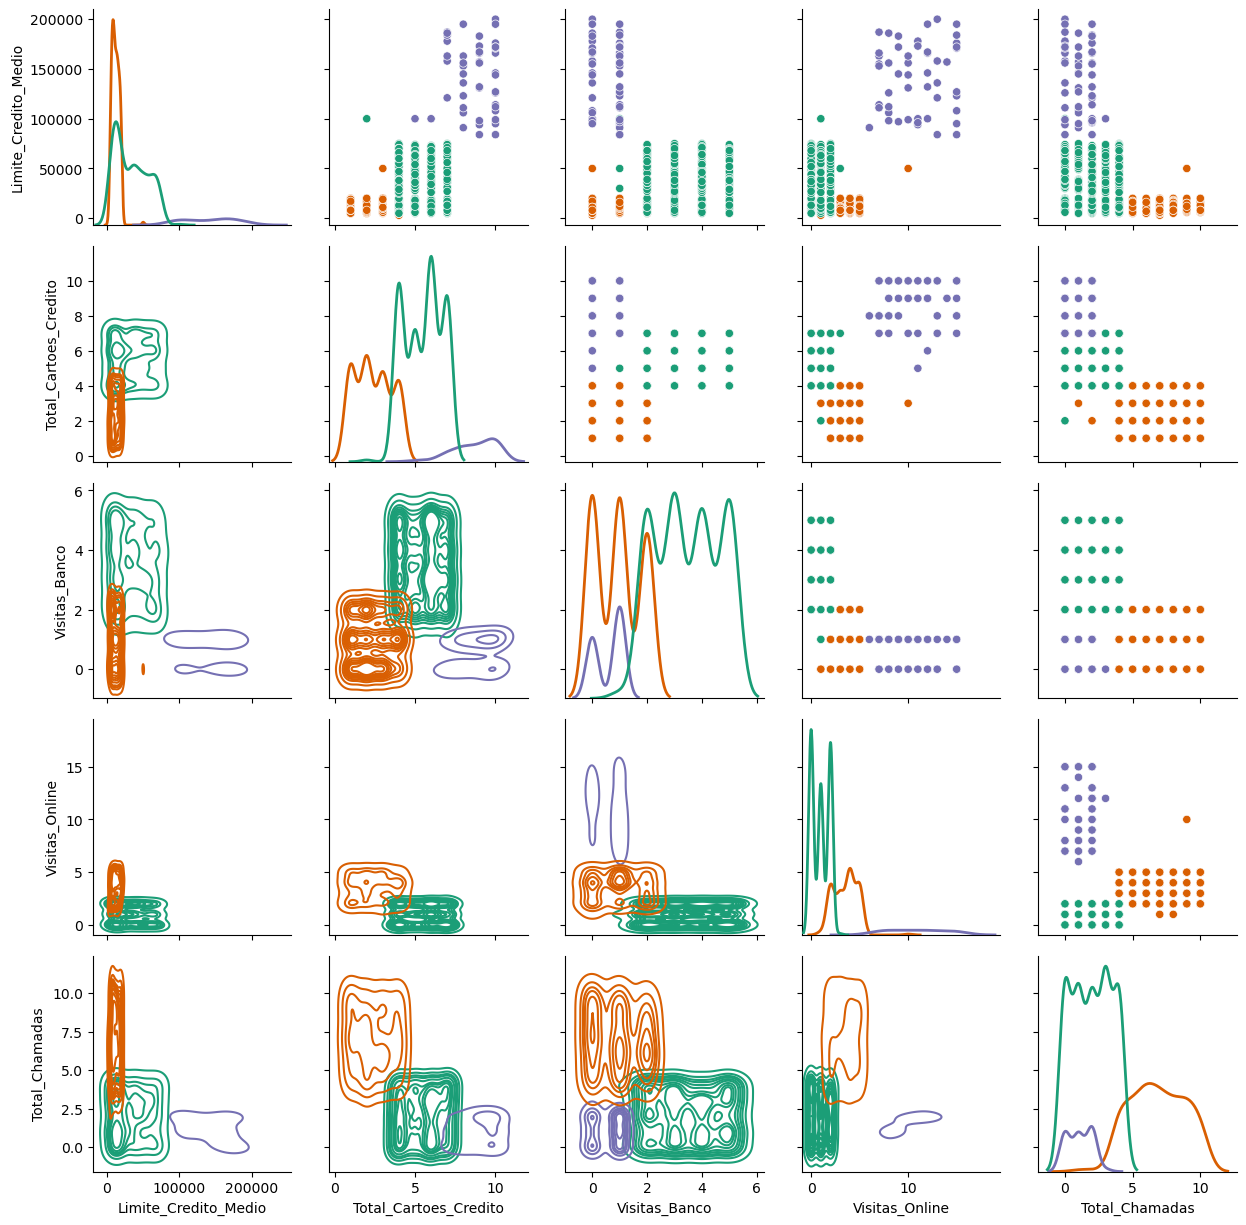

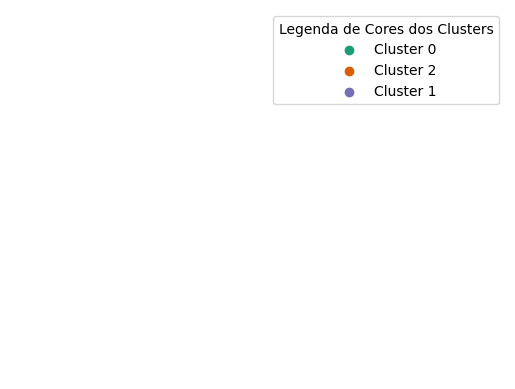

In [42]:
# Criando um mapa de cores baseado na paleta 'Dark2'
palette = sns.color_palette('Dark2', n_colors = len(dados_limpos['cluster'].unique()))  # Gera uma paleta de cores para o número único de clusters
color_map = dict(zip(dados_limpos['cluster'].unique(), palette))  # Cria um dicionário que associa cada cluster a uma cor

# Plotando o gráfico de grid com os clusters e mostrando o mapa de cores
g = sns.PairGrid(dados_limpos, hue = 'cluster', palette = color_map, diag_sharey = False)  # Cria uma grade de gráficos para visualizar os dados agrupados por cluster
g.map_upper(sns.scatterplot)  # Plota gráficos de dispersão na parte superior da grade
g.map_lower(sns.kdeplot)  # Plota gráficos de densidade de kernel na parte inferior da grade
g.map_diag(sns.kdeplot, lw = 2)  # Plota gráficos de densidade de kernel nas diagonais
plt.show()  # Exibe os gráficos gerados

# Mostrando o mapa de cores
for cluster, color in color_map.items():  # Itera sobre os clusters e suas cores associadas
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')  # Plota um ponto invisível para cada cluster para criar a legenda
plt.legend(title = 'Legenda de Cores dos Clusters')  # Exibe a legenda dos clusters
plt.axis('off')  # Remove os eixos do gráfico
plt.show()  # Exibe a legenda

# Centróides dos Clusters

In [43]:
centroides = modelo_kmeans_03.cluster_centers_
centroides

array([[-0.02106178,  0.37368962,  0.6663945 , -0.55367163, -0.55300488],
       [ 2.83176409,  1.86222621, -1.10576269,  2.82731942, -0.87432983],
       [-0.59579625, -1.05962278, -0.9015185 ,  0.32299678,  1.14810882]])

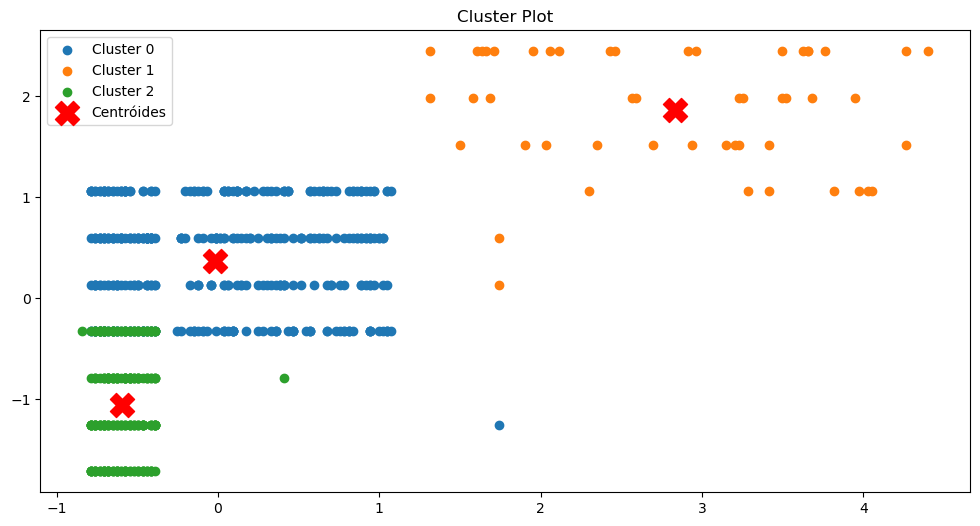

In [44]:
# Definindo o tamanho da figura do gráfico (8 x 6)
plt.figure(figsize=(12, 6))

# Laço for para iterar sobre os clusters de 0 a 2 (total de 3 clusters)
# 'range(3)' é usado para iterar pelos números dos clusters (0, 1, 2)
for cluster_num in range(3):
    # Criamos uma máscara para selecionar apenas os dados do cluster atual
    mask = dados_limpos['cluster'] == cluster_num  # Filtramos o DataFrame pelo número do cluster atual
    
    # Scatter plot para visualizar as amostras do cluster atual
    # Estamos plotando as duas primeiras colunas de 'df_scaled' para visualização em 2D
    plt.scatter(dados_padronizados[mask].iloc[:, 0], dados_padronizados[mask].iloc[:, 1], label=f'Cluster {cluster_num}')

# Adicionando os centróides ao gráfico
plt.scatter(modelo_kmeans_03.cluster_centers_[:, 0],   # Coordenada x dos centróides
            modelo_kmeans_03.cluster_centers_[:, 1],   # Coordenada y dos centróides
            s=300,                                      # Tamanho do marcador dos centróides
            c='red',                                    # Cor dos centróides (vermelho)
            marker='X',                                 # Formato do marcador dos centróides
            label='Centróides')                         # Rótulo para os centróides na legenda

# Exibindo a legenda para identificar clusters e centróides
plt.legend()
# Definindo o título do gráfico
plt.title("Cluster Plot")
# Exibindo o gráfico
plt.show()

# Análise de Silhueta

Uma métrica útil para avaliar a qualidade dos clusters é a análise de silhueta. Valores mais próximos de 1 indicam que os pontos de dados são muito semelhantes aos outros pontos de dados no mesmo cluster e muito diferentes dos pontos de dados nos outros clusters. Já valores negativos indicam que os pontos de dados podem ter sido agrupados no cluster errado.

In [45]:
round(dados_limpos.groupby('cluster').mean())  # Agrupa o DataFrame df_dsa pelo cluster e calcula a média das colunas para cada grupo

,Limite_Credito_Medio,Total_Cartoes_Credito,Visitas_Banco,Visitas_Online,Total_Chamadas
cluster,,,,,
0,33782.0,6.0,3.0,1.0,2.0
1,141040.0,9.0,1.0,11.0,1.0
2,12174.0,2.0,1.0,4.0,7.0


In [46]:
score = silhouette_score(dados_padronizados, dados_limpos['cluster'])
print(score)

0.5157182558881063


# 2D Scatter Plot (Para 2 características)

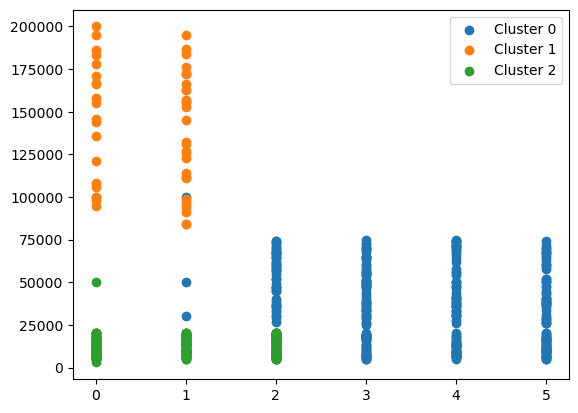

In [47]:
# Plotando os dados dos clusters em relação à Idade e Gasto Mensal
plt.scatter(dados_limpos[dados_limpos['cluster'] == 0]['Visitas_Banco'], dados_limpos[dados_limpos['cluster'] == 0]['Limite_Credito_Medio'], label='Cluster 0')  # Plota os dados do Cluster 0
plt.scatter(dados_limpos[dados_limpos['cluster'] == 1]['Visitas_Banco'], dados_limpos[dados_limpos['cluster'] == 1]['Limite_Credito_Medio'], label='Cluster 1')  # Plota os dados do Cluster 1
plt.scatter(dados_limpos[dados_limpos['cluster'] == 2]['Visitas_Banco'], dados_limpos[dados_limpos['cluster'] == 2]['Limite_Credito_Medio'], label='Cluster 2')  # Plota os dados do Cluster 2
plt.legend()  # Exibe a legenda
plt.show()  # Mostra o gráfico

# 3D Scatter Plot (Para 2 características)

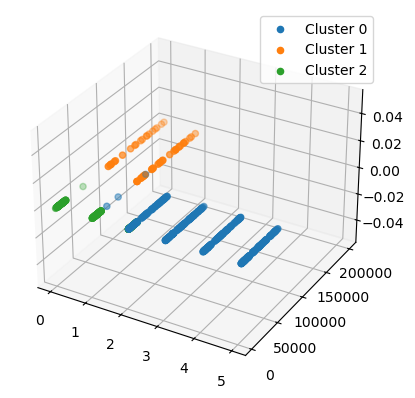

In [48]:
# Plot 3D
from mpl_toolkits.mplot3d import Axes3D  # type: ignore # Importa a ferramenta Axes3D para criar gráficos 3D

fig = plt.figure()  # Cria uma nova figura
ax = fig.add_subplot(111, projection='3d')  # Adiciona um subplot 3D à figura

# Plota os dados do Cluster 0 em 3D com Idade, Gasto Mensal e Tempo de Assinatura
ax.scatter(dados_limpos[dados_limpos['cluster'] == 0]['Visitas_Banco'], dados_limpos[dados_limpos['cluster'] == 0]['Limite_Credito_Medio'], label='Cluster 0')  
# Plota os dados do Cluster 1 em 3D
ax.scatter(dados_limpos[dados_limpos['cluster'] == 1]['Visitas_Banco'], dados_limpos[dados_limpos['cluster'] == 1]['Limite_Credito_Medio'], label='Cluster 1')  
# Plota os dados do Cluster 2 em 3D
ax.scatter(dados_limpos[dados_limpos['cluster'] == 2]['Visitas_Banco'], dados_limpos[dados_limpos['cluster'] == 2]['Limite_Credito_Medio'], label='Cluster 2') 

ax.legend()  # Exibe a legenda
plt.show()   # Mostra o gráfico 3D

# Visualização com PCA

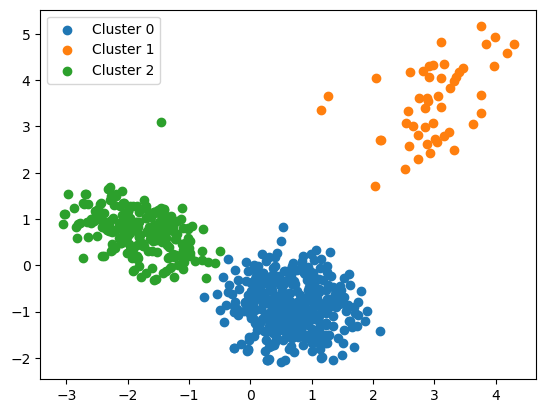

In [49]:
from sklearn.decomposition import PCA

# Cria o modelo PCA com 2 componentes principais
pca = PCA(n_components = 2)

# Treina o modelo usando dados padronizados
principalComponents = pca.fit_transform(dados_padronizados)

# Cria o dataframe com o resultado
df_principal = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])
df_principal['cluster'] = dados_limpos['cluster']

# Cria o gráfico
plt.scatter(df_principal[df_principal['cluster'] == 0]['PC 1'], df_principal[df_principal['cluster'] == 0]['PC 2'], label='Cluster 0')
plt.scatter(df_principal[df_principal['cluster'] == 1]['PC 1'], df_principal[df_principal['cluster'] == 1]['PC 2'], label='Cluster 1')
plt.scatter(df_principal[df_principal['cluster'] == 2]['PC 1'], df_principal[df_principal['cluster'] == 2]['PC 2'], label='Cluster 2')
plt.legend()
plt.show()

# Visualização com t-SNE (t-distributed Stochastic Neighbor Embedding) 

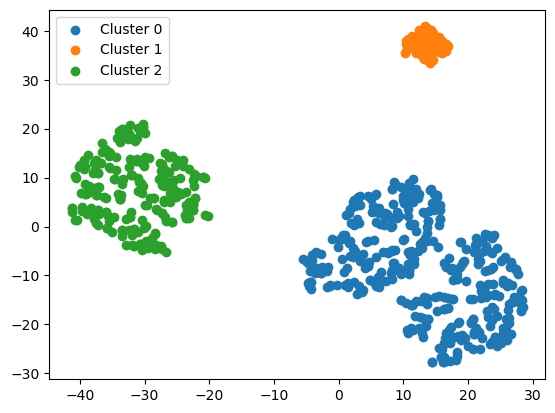

In [50]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
tsne_results = tsne.fit_transform(dados_padronizados)
df_tsne = pd.DataFrame(data = tsne_results, columns = ['tsne 1', 'tsne 2'])
df_tsne['cluster'] = dados_limpos['cluster']

plt.scatter(df_tsne[df_tsne['cluster'] == 0]['tsne 1'], df_tsne[df_tsne['cluster'] == 0]['tsne 2'], label='Cluster 0')
plt.scatter(df_tsne[df_tsne['cluster'] == 1]['tsne 1'], df_tsne[df_tsne['cluster'] == 1]['tsne 2'], label='Cluster 1')
plt.scatter(df_tsne[df_tsne['cluster'] == 2]['tsne 1'], df_tsne[df_tsne['cluster'] == 2]['tsne 2'], label='Cluster 2')
plt.legend()
plt.show()

# Cluster Plot

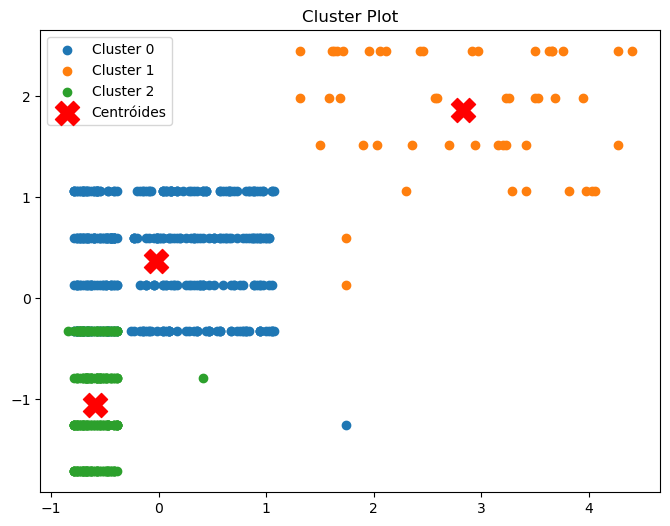

In [51]:
# Cria a figura
plt.figure(figsize = (8, 6))

# Loop pelos clusters
for cluster_num in range(3):
    mask = dados_limpos['cluster'] == cluster_num
    plt.scatter(dados_padronizados[mask].iloc[:, 0], dados_padronizados[mask].iloc[:, 1], label = f'Cluster {cluster_num}')

# Plot
plt.scatter(modelo_kmeans_03.cluster_centers_[:, 0], 
            modelo_kmeans_03.cluster_centers_[:, 1], 
            s = 300, 
            c = 'red', 
            marker = 'X', 
            label = 'Centróides')
plt.legend()
plt.title("Cluster Plot")
plt.show()

In [52]:
%reload_ext watermark
%watermark -a "Ricardo de Souuza Silva"

Author: Ricardo de Souuza Silva



In [53]:
%watermark -v -m

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : AMD64 Family 23 Model 96 Stepping 1, AuthenticAMD
CPU cores   : 12
Architecture: 64bit



In [54]:
%watermark --iversions

pandas       : 2.2.2
plotly       : 5.22.0
numpy        : 1.26.4
sklearn      : 1.4.2
matplotlib   : 3.8.4
threadpoolctl: 3.1.0
seaborn      : 0.13.2



# Fim